In [149]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.transform import Rotation
import cv2
import pandas as pd
import plotly.graph_objects as go


In [150]:
K = [ 909.95300569, 0., 635.79822139, 0., 909.95300569, 385.66617804, 0., 0., 1. ]
K = np.array(K).reshape(3, 3)

In [151]:
MOCK_DATA = True

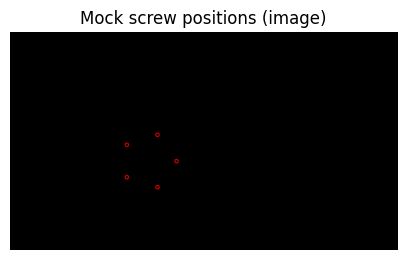

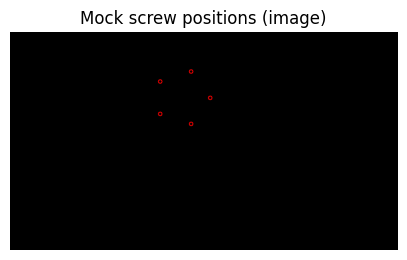

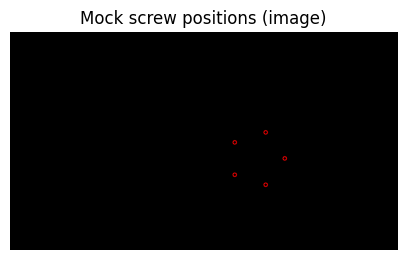

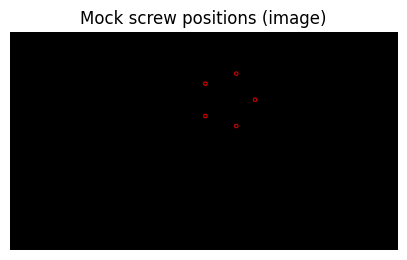

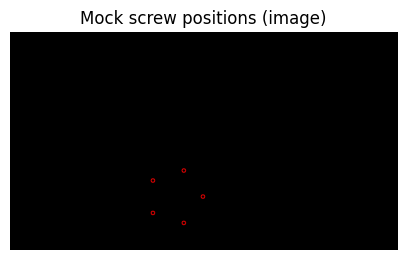

In [152]:
if MOCK_DATA:
    # Generate mock data
    screw_center = np.array([1, 0, 0])
    screw_circle_radius = 0.05
    num_screws = 5
    screw_positions = []
    for i in range(num_screws):
        ang = i * 2*np.pi / num_screws
        screw_positions.append(screw_center + np.array([screw_circle_radius*np.cos(ang), screw_circle_radius*np.sin(ang), 0]))
    mock_screw_positions = np.stack(screw_positions)

    # Mock poses
    num_pictures = 5
    cam_base_pos = [1, 0, 0.5]
    cam_rot = Rotation.from_euler("xyz",[180, 0, 0],degrees=True).as_matrix()
    poses = np.stack([np.eye(4) for i in range(num_screws)])
    for i in range(num_pictures):
        rand_ang = np.random.random()*2*np.pi
        rand_rotm = np.array([[np.cos(rand_ang), np.sin(rand_ang)],[-np.sin(rand_ang), np.cos(rand_ang)]])
        cam_pos_deviation = np.dot(rand_rotm,np.array([0,1]))
        cam_pos_deviation = 0.1*np.array([*cam_pos_deviation, 0])
        poses[i][:3,3] = cam_base_pos
        poses[i][:3,3] += cam_pos_deviation
        poses[i][:3,:3] = cam_rot
    # Pose given as cam2world

    # Mock detections
    detections = np.zeros((num_pictures, num_screws, 2))
    for i in range(num_pictures):
        cam_pose = poses[i]
        screw_positions_img = np.zeros((num_screws,2))
        for j in range(num_screws):
            screw_position_world_hom = np.hstack([mock_screw_positions[j],1])
            screw_position_cam_hom = np.dot(np.linalg.inv(cam_pose), screw_position_world_hom)
            screw_position_cam = screw_position_cam_hom[:3] / screw_position_cam_hom[-1]
            screw_position_img_hom = np.dot(K, screw_position_cam)
            screw_positions_img[j,:] = screw_position_img_hom[:2] / screw_position_img_hom[-1]
        img = np.zeros((720, 1280, 3), dtype=np.uint8)
        for (u, v) in screw_positions_img:
            u_i, v_i = int(round(u)), int(round(v))
            if 0 <= u_i < img.shape[1] and 0 <= v_i < img.shape[0]:
                cv2.circle(img, (u_i, v_i), radius=6, color=(0, 0, 255), thickness=2)
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Mock screw positions (image)")
        plt.show()

        detections[i, :] = screw_positions_img

    poses = np.repeat(poses,num_screws,axis=0)
    poses = [poses[i] for i in range(poses.shape[0])]
    img = np.repeat(list(range(num_pictures)),num_screws,axis=0)
    x = detections[:,:,0].flatten()
    y = detections[:,:,1].flatten()
    data = {
        "img": img,
        "pose": poses,
        "x": x,
        "y": y
    }

In [153]:
if not MOCK_DATA:
    # Open collected data
    with open("data/20260213_171657/_screw_detections.csv", "r") as f:
        data = f.read().splitlines()
        headers = data[0].split(",")
        data = data[1:]  # Remove header
        data_dict = {header: [] for header in headers}
        for row in data:
            values = row.split(",")
            for header, value in zip(headers, values):
                data_dict[header].append(value)
    # Make pose into TF matrices
    poses = data_dict["pose"]
    for i in range(len(poses)):
        pose = poses[i]
        pose = [float(x.split(">")[1]) for x in pose.split(";")]
        pos =  pose[:3]
        quat = pose[3:]
        matrix = np.eye(4)
        matrix[:3, 3] = pos
        matrix[:3, :3] = Rotation.from_quat(quat).as_matrix()
        data_dict["pose"][i] = matrix
    data = data_dict
    timestamps = np.unique(data["timestamp"])
    timestamp_ids = {timestamp: i for i, timestamp in enumerate(timestamps)}
    data["img"] = [timestamp_ids[t] for t in data["timestamp"]]

In [154]:
data["ray_origin"] = []
data["ray_direction"] = []

for u,v,pose in zip(data["x"], data["y"], data["pose"]):
    u = float(u)
    v = float(v)
    pixel_homogeneous = np.array([u, v, 1.0])
    ray_direction = np.linalg.inv(K) @ pixel_homogeneous
    ray_direction /= np.linalg.norm(ray_direction)  # Normalize the direction
    camera2world_pose = pose
    world2camera_pose = np.linalg.inv(camera2world_pose)
    camear2world_rot = Rotation.from_matrix(camera2world_pose[:3,:3])
    print(camear2world_rot.apply(ray_direction))
    ray_direction_rot = camear2world_rot.apply(ray_direction)
    ray_origin = camera2world_pose[:3, 3]  # Extract the translation part of the pose
    data["ray_origin"].append(ray_origin)
    data["ray_direction"].append(ray_direction_rot)

[-0.09456264 -0.04384586 -0.99455289]
[-0.16180498  0.05028195 -0.9855409 ]
[-0.26600998  0.01416163 -0.96386624]
[-0.26473836 -0.09867369 -0.95925862]
[-0.16050298 -0.13607523 -0.97761052]
[ 0.02566681  0.18266295 -0.98284051]
[-0.04134575  0.27025353 -0.96190101]
[-0.14868209  0.23498254 -0.96056069]
[-0.15177314  0.12459948 -0.98053041]
[-0.04276831  0.09029238 -0.99499656]
[ 0.28452044 -0.03325361 -0.95809306]
[ 0.22178784  0.05878621 -0.97332129]
[ 0.11525678  0.02390307 -0.99304809]
[ 0.11479581 -0.09246543 -0.98907637]
[ 0.22041359 -0.1255676  -0.96729035]
[ 0.18365084  0.17293264 -0.96766041]
[ 0.11562455  0.26232494 -0.95802745]
[ 0.00864601  0.23105518 -0.97290223]
[ 0.00882325  0.11907559 -0.99284599]
[ 0.11941007  0.08271966 -0.98939309]
[ 2.11993598e-04 -1.70782691e-01 -9.85308696e-01]
[-0.068512   -0.077802   -0.99461196]
[-0.17668832 -0.11201582 -0.97787202]
[-0.17334313 -0.22267439 -0.95935826]
[-0.06638119 -0.25868475 -0.96367823]


In [155]:
data = pd.DataFrame.from_dict(data)
data

,img,pose,x,y,ray_origin,ray_direction
0,0,"[[1.0, 0.0, 0.0, 1.0975402793197229], [0.0, -1...",549.279381,425.782369,"[1.0975402793197229, 0.022043001388886263, 0.5]","[-0.09456264417497061, -0.0438458613771937, -0..."
1,0,"[[1.0, 0.0, 0.0, 1.0975402793197229], [0.0, -1...",486.403175,339.240695,"[1.0975402793197229, 0.022043001388886263, 0.5]","[-0.1618049813141989, 0.05028195085068017, -0...."
2,0,"[[1.0, 0.0, 0.0, 1.0975402793197229], [0.0, -1...",384.667336,372.296673,"[1.0975402793197229, 0.022043001388886263, 0.5]","[-0.26600998266589765, 0.014161626438847082, -..."
3,0,"[[1.0, 0.0, 0.0, 1.0975402793197229], [0.0, -1...",384.667336,479.268064,"[1.0975402793197229, 0.022043001388886263, 0.5]","[-0.2647383606280779, -0.09867368540686208, -0..."
4,0,"[[1.0, 0.0, 0.0, 1.0975402793197229], [0.0, -1...",486.403175,512.324042,"[1.0975402793197229, 0.022043001388886263, 0.5]","[-0.16050297972391422, -0.1360752254807086, -0..."
5,1,"[[1.0, 0.0, 0.0, 1.0369425375457861], [0.0, -1...",659.561576,216.549519,"[1.0369425375457861, -0.0929260400516356, 0.5]","[0.02566680601932804, 0.1826629525080437, -0.9..."
6,1,"[[1.0, 0.0, 0.0, 1.0369425375457861], [0.0, -1...",596.685370,130.007846,"[1.0369425375457861, -0.0929260400516356, 0.5]","[-0.04134575260871714, 0.2702535269267096, -0...."
7,1,"[[1.0, 0.0, 0.0, 1.0369425375457861], [0.0, -1...",494.949531,163.063823,"[1.0369425375457861, -0.0929260400516356, 0.5]","[-0.14868209102772378, 0.2349825431848278, -0...."
8,1,"[[1.0, 0.0, 0.0, 1.0369425375457861], [0.0, -1...",494.949531,270.035215,"[1.0369425375457861, -0.0929260400516356, 0.5]","[-0.15177313930689618, 0.1245994847091798, -0...."
9,1,"[[1.0, 0.0, 0.0, 1.0369425375457861], [0.0, -1...",596.685370,303.091193,"[1.0369425375457861, -0.0929260400516356, 0.5]","[-0.04276831096713646, 0.09029238427797669, -0..."


In [156]:
def plot_poses(poses, scale=0.05, axis_labels=True, ax=None, figsize=(8, 6)):
    """
    Visualize 4x4 pose matrices as coordinate frames using Plotly.
    - poses: single 4x4 array or iterable/array of shape (N,4,4)
    - scale: length of drawn axes
    - axis_labels: annotate axes ('x','y','z') for each pose
    - ax: ignored (kept for compatibility)
    Returns the plotly Figure.
    """
    poses = np.asarray(poses)
    if poses.ndim == 2 and poses.shape == (4, 4):
        poses = poses[None, ...]
    assert poses.ndim == 3 and poses.shape[1:] == (4, 4), "poses must be (N,4,4) or (4,4)"

    fig = go.Figure()
    all_points = []

    for i, pose in enumerate(poses):
        t = pose[:3, 3]
        R = pose[:3, :3]
        for vec, color, lbl in zip(R.T, ("red", "green", "blue"), ("x", "y", "z")):
            end = t + vec * scale
            line = np.vstack([t, end])
            fig.add_trace(go.Scatter3d(
                x=line[:, 0], y=line[:, 1], z=line[:, 2],
                mode="lines", line=dict(color=color, width=4), showlegend=False
            ))
            fig.add_trace(go.Scatter3d(
                x=[t[0]], y=[t[1]], z=[t[2]],
                mode="markers", marker=dict(color=color, size=4), showlegend=False
            ))
            if axis_labels:
                fig.add_trace(go.Scatter3d(
                    x=[end[0]], y=[end[1]], z=[end[2]],
                    mode="text", text=[f"{lbl}{i}"], textposition="top center",
                    showlegend=False
                ))
        all_points.extend([t, t + R[:, 0] * scale, t + R[:, 1] * scale, t + R[:, 2] * scale])

    all_points = np.vstack(all_points)
    mins = all_points.min(axis=0)
    maxs = all_points.max(axis=0)
    centers = 0.5 * (mins + maxs)
    radius = (maxs - mins).max() / 2.0

    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X", range=[centers[0] - radius, centers[0] + radius]),
            yaxis=dict(title="Y", range=[centers[1] - radius, centers[1] + radius]),
            zaxis=dict(title="Z", range=[centers[2] - radius, centers[2] + radius]),
        ),
        width=figsize[0] * 100,
        height=figsize[1] * 100,
    )
    # fig.show()
    return fig

plot_poses(np.stack(data["pose"].values))

In [157]:
img_indices = data["img"].unique()

# Choose only poses with large baseline
unique_img_poses = []
for img in img_indices:
    img_data = data[data["img"] == img]
    img_poses = np.stack(img_data["pose"].values)
    # Check that all detections of same image have same pose
    assert len(np.unique(img_poses,axis=0)) == 1, np.unique(img_poses,axis=0)
    img_pose = img_poses[0,...]
    unique_img_poses.append(img_pose)

camera_positions = np.stack(unique_img_poses)[:,:3,3]
pairwise_dists = np.linalg.norm(camera_positions[None,...]-camera_positions[:,None,...], axis=2)
max_pairwise_dists = np.argmax(pairwise_dists.ravel())
pairwise_dists
max_pair = np.unravel_index(max_pairwise_dists, pairwise_dists.shape)
camera_positions[max_pair[0]], camera_positions[max_pair[1]]

(array([ 0.95510574, -0.08935606,  0.5       ]),
 array([1.04989242, 0.08666456, 0.5       ]))

In [158]:
# # Select known subset
# img_subset = [0, 6, 14]
# data = data[data["img"].isin(img_subset)]
# img_indices = img_subset

In [159]:
def closest_point_between_rays(ray1_origin, ray1_direction, ray2_origin, ray2_direction):
    # Compute the cross product of the direction vectors
    cross = np.cross(ray1_direction, ray2_direction)
    denom = np.linalg.norm(cross) ** 2
    
    # If the rays are parallel (cross product is zero), return None
    if denom < 1e-6:
        return None
    
    # Compute the parameters for the closest points on each ray
    t1 = np.linalg.det([ray2_origin - ray1_origin, ray2_direction, cross]) / denom
    t2 = np.linalg.det([ray2_origin - ray1_origin, ray1_direction, cross]) / denom
    
    # Compute the closest points on each ray
    closest_point_ray1 = ray1_origin + t1 * ray1_direction
    closest_point_ray2 = ray2_origin + t2 * ray2_direction

    # Get the distance between the closest points
    distance = np.linalg.norm(closest_point_ray1 - closest_point_ray2)
    
    # Return the midpoint between the two closest points as the best estimate
    return (closest_point_ray1 + closest_point_ray2) / 2, distance

In [167]:
def reprojection_error(point3D_hyp, point2D_meas, pose):
    point3D_hyp_hom = np.hstack((point3D_hyp, 1))
    point3D_hyp_hom = np.dot(pose, point3D_hyp_hom)
    point3D_hyp = point3D_hyp[:3] / point3D_hyp[-1]
    point2D_hyp = np.dot(K, point3D_hyp)
    point2D_hyp = point2D_hyp[:2] / point2D_hyp[-1]
    error = np.linalg.norm(point2D_hyp, point2D_meas)
    return error

Ray pairing between maximum distance images

In [168]:

# Visualize the rays and the closest point

def plot_rays(ray_origins, ray_directions, colors="red", name="ray"):
    if isinstance(colors, str):
        colors = [colors for i in range(ray_origins.shape[0])]
        print(colors)
    fig = go.Figure()
    for o, d, color in zip(ray_origins, ray_directions, colors):
        line = np.vstack([o, o + d])
        fig.add_trace(go.Scatter3d(
            x=line[:, 0], y=line[:, 1], z=line[:, 2],
            mode="lines", line=dict(color=color), name=name, showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[o[0]], y=[o[1]], z=[o[2]],
            mode="markers", marker=dict(color=color, size=4), showlegend=False
        ))
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
    fig.show()

def plot_two_rays_with_closest(ray_o1, ray_d1, ray_o2, ray_d2, closest_point):
    ray1_line = np.vstack([ray_o1, ray_o1 + ray_d1])
    ray2_line = np.vstack([ray_o2, ray_o2 + ray_d2])

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=ray1_line[:, 0], y=ray1_line[:, 1], z=ray1_line[:, 2],
                               mode="lines", line=dict(color="red"), name="ray1"))
    fig.add_trace(go.Scatter3d(x=ray2_line[:, 0], y=ray2_line[:, 1], z=ray2_line[:, 2],
                               mode="lines", line=dict(color="blue"), name="ray2"))
    fig.add_trace(go.Scatter3d(x=[ray_o1[0]], y=[ray_o1[1]], z=[ray_o1[2]],
                               mode="markers", marker=dict(color="red", size=5), name="ray1_origin"))
    fig.add_trace(go.Scatter3d(x=[ray_o2[0]], y=[ray_o2[1]], z=[ray_o2[2]],
                               mode="markers", marker=dict(color="blue", size=5), name="ray2_origin"))
    fig.add_trace(go.Scatter3d(x=[closest_point[0]], y=[closest_point[1]], z=[closest_point[2]],
                               mode="markers", marker=dict(color="green", size=6), name="closest_point"))
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
    fig.show()


In [169]:
img_data1 = data[data["img"] == np.random.choice(img_indices)]
img_data2 = data[data["img"] == np.random.choice(img_indices)]

closest_points = {}
for idx1, detection1 in img_data1.iterrows():
    ray_o1 = detection1["ray_origin"]
    ray_d1 = detection1["ray_direction"]

    for idx2, detection2 in img_data2[["ray_origin", "ray_direction"]].iterrows():
        ray_o2 = detection2["ray_origin"]
        ray_d2 = detection2["ray_direction"]

        closest_point, distance = closest_point_between_rays(
            np.array(ray_o1),
            np.array(ray_d1),
            np.array(ray_o2),
            np.array(ray_d2),
        )
        closest_points[(idx1, idx2)] = (closest_point, distance)

plot_two_rays_with_closest(ray_o1, ray_d1, ray_o2, ray_d2, closest_point)
closest_point

array([ 1.01545085e+00, -4.75528258e-02, -1.66533454e-16])

In [170]:
cmap = plt.get_cmap()
colors = cmap(data["img"]/max(data["img"]))

plot_rays(
    np.concatenate([data["ray_origin"].to_list(), data["ray_origin"].to_list()]), 
    np.concatenate([data["ray_direction"].to_list(), data["ray_direction"].to_list()]),
    colors=colors
)


Ray pairing between random images

In [ ]:
img_indices = data["img"].unique()
img1, img2 = np.random.choice(img_indices, size=2, replace=False)
rays1 = data[data["img"] == img1]
rays2 = data[data["img"] == img2]

iters = 1000
k = 3

for iter in range(iters):
    subset_img_indices = np.random.choice(img_indices, size=k, replace=False) 
	

closest_point = closest_point_between_rays(
	np.array(row1["ray_origin"]),
	np.array(row1["ray_direction"]),
	np.array(row2["ray_origin"]),
	np.array(row2["ray_direction"]),
)
closest_point

NameError: name 'row1' is not defined